# Identification of selective sweeps

## Setup

In [1]:
.libPaths('../renv/library/R-3.6/x86_64-conda-linux-gnu/')

In [269]:
# Load require packages
library(tidyverse)
library(data.table)
library(bedtoolsr)
library(patchwork)

In [3]:
# Prefix for results
results_prefix <- '/scratch/projects/trifolium/gwsd/results/'

### Functions

In [4]:
# Function to load windowd thetas 
load_windowed_thetas <- function(path){
    habitat <- str_extract(basename(path), '(?<=allSites_)(\\w+)(?=_windowed)')

    df <- suppressMessages(read_delim(path, delim = '\t')) %>%
        rename(region = 1) %>% 
        mutate(tp_scaled = tP / nSites,
               habitat = habitat) %>%
        dplyr::select(-tF, -tH, -tL, -fuf, -fud, -fayh, -zeng, -tW, -tP, -starts_with('#'))
    return(df)
}

# Function to load windowed Fst
load_windowed_fst <- function(path){
    chrom <- str_extract(basename(path), '^(.+)(?=_allSites)')
    hab_comb <- str_extract(basename(path), '(?<=allSites_)(\\w+_\\w+)(?=_windowed)')
    
    colnames <- c('region', 'Chr', 'WinCenter', 'nSites_fst', 'fst')
    df <- suppressMessages(read_delim(path, delim = '\t', skip = 1, col_names = colnames)) %>%
        
        # Set negative Fst values to 0
        mutate(fst = ifelse(fst < 0, 0, fst))
    
    return(df)
}

#' Calculate mean cM of markers in window
#' 
#' @param chrom_name Character vector with name of chromosome
#' @param window_size Size of window in bp
#' @param step Number of base pairs to shift window
#' @param df Dataframe with windowed markers
#'
#' @return Dataframe with mean cM in windows
calculate_windowed_stats <- function(df, window_size, step, thresh){
    
    chrom <- df %>% pull(Chr) %>% unique()
    print(sprintf("Processing chromosome %s", chrom))
    
    winStarts <- seq(from = min(df$pos), to = max(df$pos), by = step)

    mat = matrix(0, nrow = length(winStarts), ncol = 13)
    for(i in 1:length(winStarts)){
        start = winStarts[i]
        end = start + step
        df_filt <- df %>% filter(pos >= start & pos < end)
        
        winID = i
        winCenter = start + (step / 2)
        mean = suppressWarnings(mean(df_filt$normxpnsl))
        max = suppressWarnings(max(df_filt$normxpnsl))
        min = suppressWarnings(min(df_filt$normxpnsl))
        n = nrow(df_filt)
        num_gt_thresh = sum(df_filt$normxpnsl > thresh)
        num_lt_thresh = sum(df_filt$normxpnsl < -thresh)
        gt_frac = sum(num_gt_thresh) / n
        lt_frac = sum(num_lt_thresh) / n
        
        stats <- c(chrom, winID, start, end, winCenter, mean, max, min, n, num_gt_thresh, num_lt_thresh, gt_frac, lt_frac)
        mat[i,] <- stats
        }
    
    stats_df <- as.data.frame(mat)
    names(stats_df) <- c('Chr', 'winID', 'start', 'end', 'winCenter', 'mean', 'max', 'min', 'n', 'num_gt_thresh', 'num_lt_thresh', 'gt_frac', 'lt_frac')
    return(stats_df)
}


load_xpnsl_norm <- function(path, type){
    
    if(type == 'raw'){
        col_names <- TRUE
    }else{
        col_names <- c('start', 'end', 'num_scores', 'frac_gt', 'frac_lt', 'gt_thresh', 'lt_thresh', 'max', 'min')
    }
    chrom_name <- str_extract(basename(path), pattern = '.+(?=_Urban)')
    df <- suppressMessages(read_delim(path, delim = '\t', col_names = col_names)) %>% 
        mutate(Chr = chrom_name)
    return(df)
    
}

mark_xpnsl_outliers <- function(df_raw_scores, outlier_windows){
    
    gt_windows <- outlier_windows %>% filter(gt_thresh == 1)
    lt_windows <- outlier_windows %>% filter(lt_thresh == 1)

    gt_range <- data.table(start = gt_windows$start, end = gt_windows$end)
    lt_range <- data.table(start = lt_windows$start, end = lt_windows$end)
    
    gt_filt <- setDT(df_raw_scores)[pos %inrange% gt_range]
    lt_filt <- setDT(df_raw_scores)[pos %inrange% lt_range]
    
    df_raw_scores_mod <- df_raw_scores %>% 
        mutate(outlier_cat = case_when(pos %in% gt_filt$pos ~ 'Urban sel',
                                       pos %in% lt_filt$pos ~ 'Rural sel',
                                       TRUE ~ 'Not outlier'))
    
    return(df_raw_scores_mod)
}

## SFS-based tests

- I estimated $\theta_{\pi}$, Tajima's D, and $F_{ST}$ in 5 Kb non-overlapping windows across the genome
- For each window, I will estimate the difference in $\theta_{\pi}$ and Tajima's D between urban and rural habitats (i.e., $\Delta\theta_{\pi}$ and $\Delta$Td)
- I'll define outlier regions as those with:
    1. Lower/Higher $\Delta\theta_{\pi}$ than the genome-wide average (top 1%)
    2. Lower/Higher $\Delta$Td than the genome-wide average (top 1%)
    3. Higher $F_{ST}$ than the genome-wide average (top 1%)

In [5]:
# Load Fst
fst_path <- paste0(results_prefix, 'angsd/summary_stats/hudson_fst/byHabitat/allSites')
fst_df <- list.files(fst_path, recursive = TRUE, full.names = TRUE, pattern = '.+_allSites_Urban_Rural_windowed.fst') %>%
    purrr::map_dfr(., load_windowed_fst) %>% 
    mutate(region = str_extract(region, pattern = '(?<=\\()\\d+,\\d+(?=\\)$)')) %>% 
    separate(region, into = c('start', 'end'), sep = ',') %>% 
    mutate(chrom_pos = paste0(Chr, '_', WinCenter))

In [6]:
# Load summary stats (i.e., pi and Tajima's D)
# Currently ignores suburban habitats
thetas_path <- paste0(results_prefix, 'angsd/summary_stats/thetas/byHabitat/allSites')
thetas_df <- list.files(thetas_path, recursive = TRUE, pattern = '.+_allSites_(Rural|Urban)_windowedThetas.gz.pestPG', full.names = TRUE) %>%
    purrr::map_dfr(., load_windowed_thetas) %>% 
    mutate(region = str_extract(region, pattern = '(?<=\\()\\d+,\\d+(?=\\)$)')) %>% 
    separate(region, into = c('start', 'end'), sep = ',') %>% 
    mutate(chrom_pos = paste0(Chr, '_', WinCenter))

In [7]:
# Convert to wide format for calculating habitat differences, etc
thetas_df_wide <- thetas_df %>% 
    pivot_wider(values_from = c('Tajima', 'nSites', 'tp_scaled'), names_from = 'habitat')

In [8]:
# Combine windowed theta and fst estimates into single df
# Calculate difference in pi and Tajima's D
total_windows_theta <- nrow(thetas_df_wide)
total_windows_fst <- nrow(fst_df)

allStats_windowed_df <- thetas_df_wide %>%
    filter(chrom_pos %in% fst_df$chrom_pos) %>%
    left_join(., fst_df, by = c('chrom_pos', 'Chr','start', 'end', 'WinCenter')) %>%
    mutate(delta_tp_ur = tp_scaled_Urban - tp_scaled_Rural,
           delta_td_ur = Tajima_Urban - Tajima_Rural)

total_windows_allStats <- nrow(allStats_windowed_df)

print(sprintf('There are %s windows with estimates of fst and %s windows with estimates of thetas', total_windows_fst, total_windows_theta))
print(sprintf('%s windows were missing from the Fst Dataframe. %s windows remaining', total_windows_theta - total_windows_fst, total_windows_allStats))

[1] "There are 161499 windows with estimates of fst and 178473 windows with estimates of thetas"
[1] "16974 windows were missing from the Fst Dataframe. 161499 windows remaining"


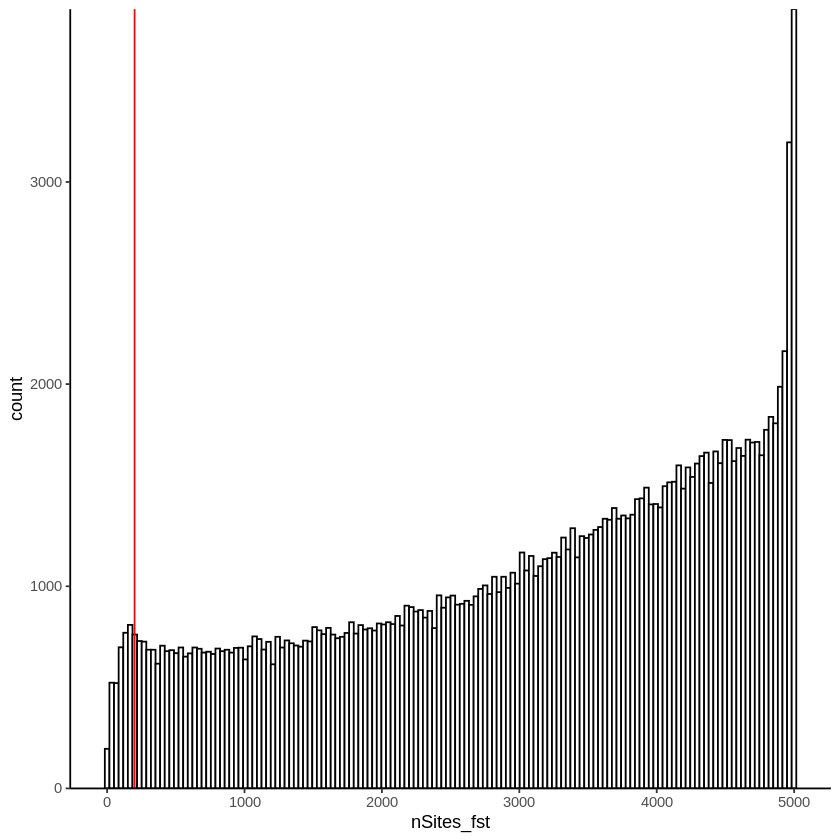

In [9]:
# What does the distribution of the number of sites per window look like?
# Keep windows with at least 200 sites. 
allStats_windowed_df %>% 
    ggplot(., aes(x = nSites_fst)) +
    geom_histogram(bins = 150, color = 'black', fill = 'white') +
    geom_vline(xintercept = 200, color = 'red') +
    scale_y_continuous(expand = c(0, 0)) +
    theme_classic()

In [10]:
# Identify outliers across genome
nSites_thresh <- 200
allStats_windowed_filt <- allStats_windowed_df %>%
    filter_at(vars(starts_with('nSites')), ~ . >= nSites_thresh)

fst_quant_filt <- quantile(allStats_windowed_filt %>% pull(fst), probs = c(0.99))
tp_quant_filt <- quantile(allStats_windowed_filt %>% pull(delta_tp_ur), probs = c(0.01, 0.99))
td_quant_filt <- quantile(allStats_windowed_filt %>% pull(delta_td_ur), probs = c(0.01, 0.99))

fst_vals <- allStats_windowed_filt %>% pull(fst)
num_sites <- nrow(fst_quant_filt)

allStats_windowed_filt <- allStats_windowed_filt %>%
    mutate(fst_outlier = ifelse(fst >= fst_quant_filt, 1, 0),
           tp_outlier = ifelse(delta_tp_ur <= tp_quant_filt[1] | delta_tp_ur >= tp_quant_filt[2], 1, 0),
           td_outlier = ifelse(delta_td_ur <= td_quant_filt[1] | delta_td_ur >= td_quant_filt[2], 1, 0),
           all_outlier = ifelse(fst_outlier == 1 & tp_outlier == 1 & td_outlier == 1, 1, 0)) %>%
    dplyr::select(chrom_pos, Chr, start, end, WinCenter, fst, delta_tp_ur, delta_td_ur, contains('_outlier'))

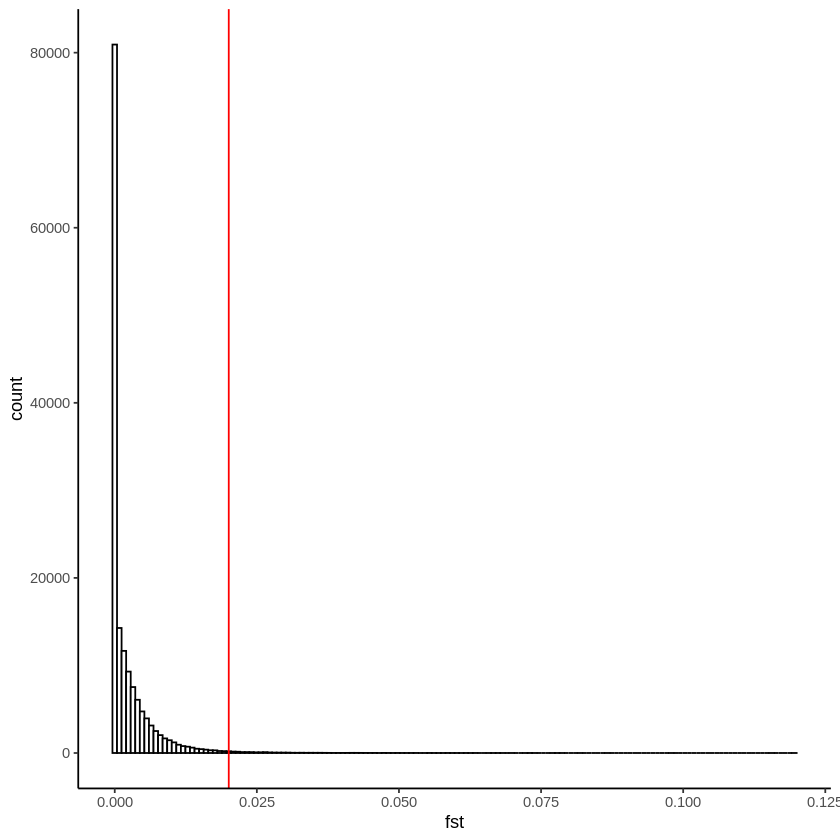

In [11]:
allStats_windowed_filt %>% 
    ggplot(., aes(x = fst)) +
    geom_histogram(bins = 150, color = 'black', fill = 'white') +
#     scale_y_continuous(expand = c(0, 0)) +
    geom_vline(xintercept = fst_quant_filt[1], color = 'red') +
    theme_classic()

In [12]:
allStats_windowed_filt %>% 
    group_by(fst_outlier, tp_outlier, td_outlier) %>%
    summarise(n = n())

fst_outlier,tp_outlier,td_outlier,n
<dbl>,<dbl>,<dbl>,<int>
0,0,0,151045
0,0,1,2045
0,1,0,2268
0,1,1,665
1,0,0,1077
1,0,1,280
1,1,0,57
1,1,1,162


In [13]:
# Add habitat under selection based on difference in pi and Tajima's D
allStats_windowed_filt <- allStats_windowed_filt %>% 
    mutate(direction = case_when(delta_tp_ur < 0 & delta_td_ur < 0 ~ 'Urban sel',
                                 delta_tp_ur > 0 & delta_td_ur > 0 ~ 'Rural sel',
                                 TRUE ~ 'Weird'))

In [14]:
allStats_windowed_filt %>% filter(all_outlier == 1) %>% group_by(direction) %>% summarise(n = n())

direction,n
<chr>,<int>
Rural sel,88
Urban sel,73
Weird,1


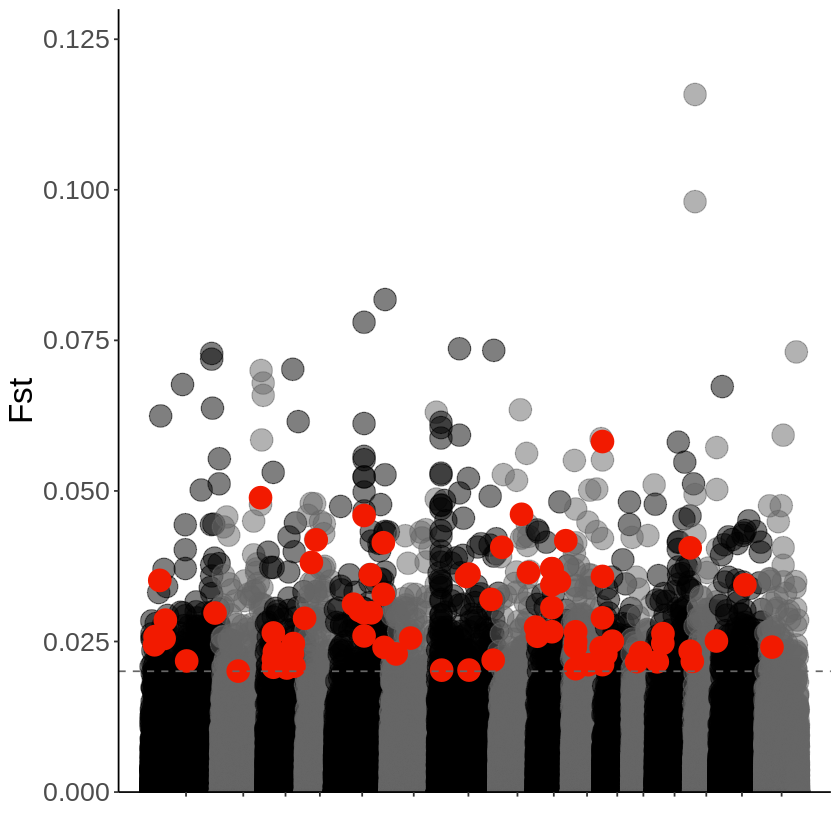

In [312]:
data_cum <- allStats_windowed_filt %>% 
    group_by(Chr) %>% 
    summarise(max_WinCenter = max(WinCenter)) %>% 
    mutate(WinCenter_add = lag(cumsum(max_WinCenter), default = 0)) %>% 
    dplyr::select(Chr, WinCenter_add)

allStats_windowed_filt_mod <- allStats_windowed_filt %>%
    inner_join(data_cum, by = "Chr") %>% 
    mutate(WinCenter_cum = WinCenter + WinCenter_add) 

axis_set <- allStats_windowed_filt_mod %>% 
  group_by(Chr) %>% 
  summarize(center = mean(WinCenter_cum))

urban_outliers <- allStats_windowed_filt_mod %>% filter(all_outlier == 1 & direction == 'Urban sel')
rural_outliers <- allStats_windowed_filt_mod %>% filter(all_outlier == 1 & direction == 'Rural sel')

manhat_plot <- allStats_windowed_filt_mod %>%
    mutate(chrom_cat = case_when(Chr == 'CM019101.1' ~ 'One',
                                 Chr == 'CM019102.1' ~ 'Two',
                                 Chr == 'CM019103.1' ~ 'One',
                                 Chr == 'CM019104.1' ~ 'Two',
                                 Chr == 'CM019105.1' ~ 'One',
                                 Chr == 'CM019106.1' ~ 'Two',
                                 Chr == 'CM019107.1' ~ 'One',
                                 Chr == 'CM019108.1' ~ 'Two',
                                 Chr == 'CM019109.1' ~ 'One',
                                 Chr == 'CM019110.1' ~ 'Two',
                                 Chr == 'CM019111.1' ~ 'One',
                                 Chr == 'CM019112.1' ~ 'Two',
                                 Chr == 'CM019113.1' ~ 'One',
                                 Chr == 'CM019114.1' ~ 'Two',
                                 Chr == 'CM019115.1' ~ 'One',
                                 Chr == 'CM019116.1' ~ 'Two')) %>%
    filter(all_outlier != 1) %>% 
    ggplot(aes(x = WinCenter_cum, y = fst)) +
        geom_point(shape = 21, alpha = 0.5, size = 6, aes(fill = chrom_cat, color = chrom_cat)) +
        geom_point(data = urban_outliers, shape = 21, alpha = 1, size = 6, color = '#F21A00', fill = '#F21A00') +
#         geom_point(data = rural_outliers, shape = 21, alpha = 1, size = 1, color = 'green', fill = 'green') +
        geom_hline(yintercept = fst_quant_filt, color = "grey40", linetype = "dashed") +
        scale_x_continuous(label = axis_set$Chr, breaks = axis_set$center) +
        scale_y_continuous(expand = c(0,0)) +
        coord_cartesian(ylim = c(0, 0.13)) +
#         scale_fill_manual(values = c("#46ACC8", "#E58601")) + 
#         scale_color_manual(values = c("#46ACC8", "#E58601")) + 
        scale_fill_manual(values = c("black", "grey40")) + 
        scale_color_manual(values = c("black", "grey40")) + 
        ylab('Fst') + xlab('') +
        theme_classic() +
        theme(
#             aspect.ratio = 0.4,
            legend.position = "none",
            panel.border = element_blank(),
            panel.grid.major.x = element_blank(),
            panel.grid.minor.x = element_blank(),
            axis.text = element_text(size=16),
            axis.title = element_text(size=20),
            axis.text.x = element_blank(),
#             axis.title.x = element_blank()
          )
manhat_plot

In [306]:
figures_path <- "/scratch/projects/trifolium/gwsd/figures_forThesis/"
ggsave(filename = paste0(figures_path, 'fst_manhat.pdf'), plot = manhat_plot, device = 'pdf', 
       width = 20, height = 6, units = 'in', dpi = 600, )

In [23]:
allStats_windowed_filt_urbanSel_withRanks <- allStats_windowed_filt %>% 
    filter(all_outlier == 1 & direction == 'Urban sel') %>% 
    arrange(desc(fst)) %>% 
    mutate(fst_rank = 1:n()) %>% 
    dplyr::select(-chrom_pos) %>% 
    arrange(Chr, WinCenter)

In [74]:
allStats_windowed_filt_urbanSel_merged <- bt.merge(i = allStats_windowed_filt_urbanSel_withRanks)
names(allStats_windowed_filt_urbanSel_merged) <- c('Chr', 'start', 'end')
allStats_windowed_filt_urbanSel_merged <- allStats_windowed_filt_urbanSel_merged %>% 
    mutate(winSize = end - start)

print(sprintf('There were %s Fst outlier windows prior to merging. There are %s outlier regions after merging consecutive outlier windows',
              nrow(allStats_windowed_filt_urbanSel_withRanks), nrow(allStats_windowed_filt_urbanSel_merged)))

[1] "There were 73 Fst outlier windows prior to merging. There are 65 outlier regions after merging consecutive outlier windows"


## XP-nSL (manual windows)

- XP-nSL is a haplotype-based scan for selective sweeps
- I calculated windowed stats using normalized XP-nSL

In [27]:
xpnsl_path <- '../../results/sweeps/xpnsl/'
pattern <- '.+_Urban_Rural.xpnsl.out.norm$'
xpnsl_raw_df <- list.files(xpnsl_path, recursive = TRUE, full = TRUE, pattern = pattern) %>% 
    map_dfr(., load_xpnsl_norm, type = 'raw') %>% 
    rename('normxpnsl' = 'normxpehh') %>% 
    dplyr::select(-id)

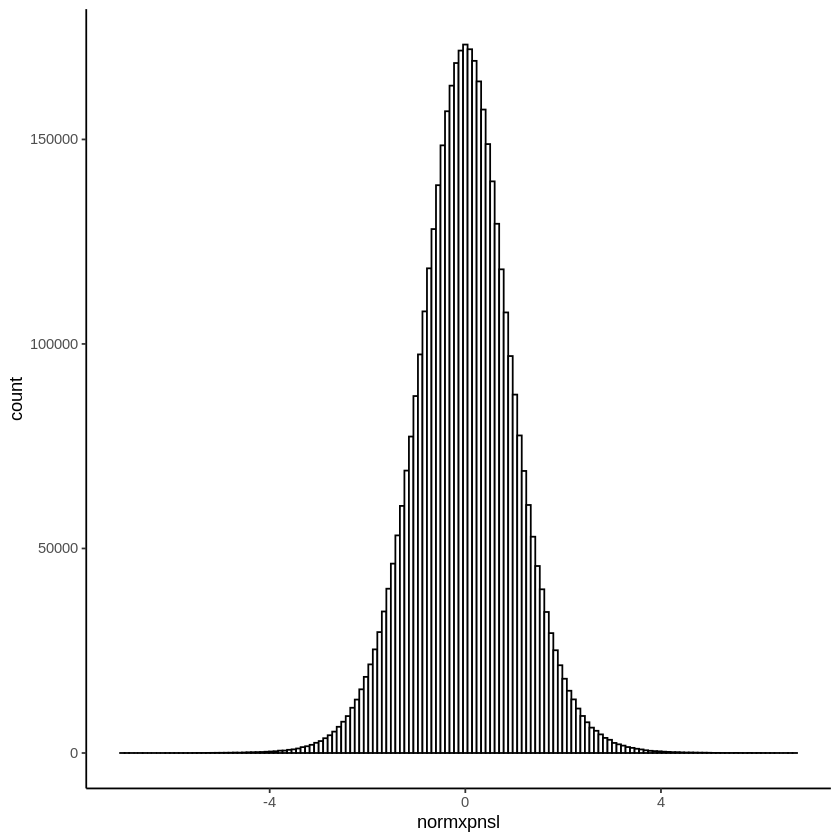

In [28]:
ggplot(xpnsl_raw_df, aes(x = normxpnsl)) +
    geom_histogram(bins = 150, color = 'black', fill = 'white') +
    theme_classic()

In [29]:
window_size = 50000
step = 50000
thresh = 2
xpnsl_windows <- xpnsl_raw_df %>% 
    group_split(Chr) %>% 
    purrr::map_dfr(., calculate_windowed_stats, window_size = window_size, step = step, thresh = thresh)

[1] "Processing chromosome CM019101.1"
[1] "Processing chromosome CM019102.1"
[1] "Processing chromosome CM019103.1"
[1] "Processing chromosome CM019104.1"
[1] "Processing chromosome CM019105.1"
[1] "Processing chromosome CM019106.1"
[1] "Processing chromosome CM019107.1"
[1] "Processing chromosome CM019108.1"
[1] "Processing chromosome CM019109.1"
[1] "Processing chromosome CM019110.1"
[1] "Processing chromosome CM019111.1"
[1] "Processing chromosome CM019112.1"
[1] "Processing chromosome CM019113.1"
[1] "Processing chromosome CM019114.1"
[1] "Processing chromosome CM019115.1"
[1] "Processing chromosome CM019116.1"


Warning message in bind_rows_(x, .id):
“Unequal factor levels: coercing to character”Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”Warning message in bind_rows_(x, .id):
“Unequal factor levels: coercing to character”Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”Warning message in bind_rows_(x, .id):
“Unequal factor levels: coercing to character”Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”Warning message in bind_rows_(x, .id):
“Unequal factor levels: coercing to character”Warning mess

“binding character and factor vector, coercing into character vector”Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”Warning message in bind_rows_(x, .id):
“binding character and facto

In [30]:
# Identify outliers across genome
nSites_thresh <- 10
xpnsl_windows_filt <- xpnsl_windows %>%
    mutate_at(vars(-("Chr")),as.numeric) %>% 
    filter(n >= nSites_thresh)

xpnsl_score_quant_filt <- quantile(xpnsl_windows_filt %>% pull(mean), probs = c(0.01, 0.99))
xpnsl_gtprop_quant_filt <- quantile(xpnsl_windows_filt %>% pull(gt_frac), probs = 0.99)
xpnsl_ltprop_quant_filt <- quantile(xpnsl_windows_filt %>% pull(lt_frac), probs = 0.99)

xpnsl_windows_filt <- xpnsl_windows_filt %>%
    mutate(xpnsl_score_outlier = ifelse(mean <= xpnsl_score_quant_filt[1] | mean >= xpnsl_score_quant_filt[2], 1, 0),
           xpnsl_gtprop_outlier = ifelse(gt_frac >= xpnsl_gtprop_quant_filt, 1, 0),
           xpnsl_ltprop_outlier = ifelse(lt_frac >= xpnsl_ltprop_quant_filt, 1, 0),
           direction = case_when(xpnsl_score_outlier == 1 & mean > 0 & xpnsl_gtprop_outlier == 1 ~ 'Urban sel',
                                 xpnsl_score_outlier == 1 & mean < 0 & xpnsl_ltprop_outlier == 1 ~ 'Rural sel',
                                 TRUE ~ 'Not dual outlier'))

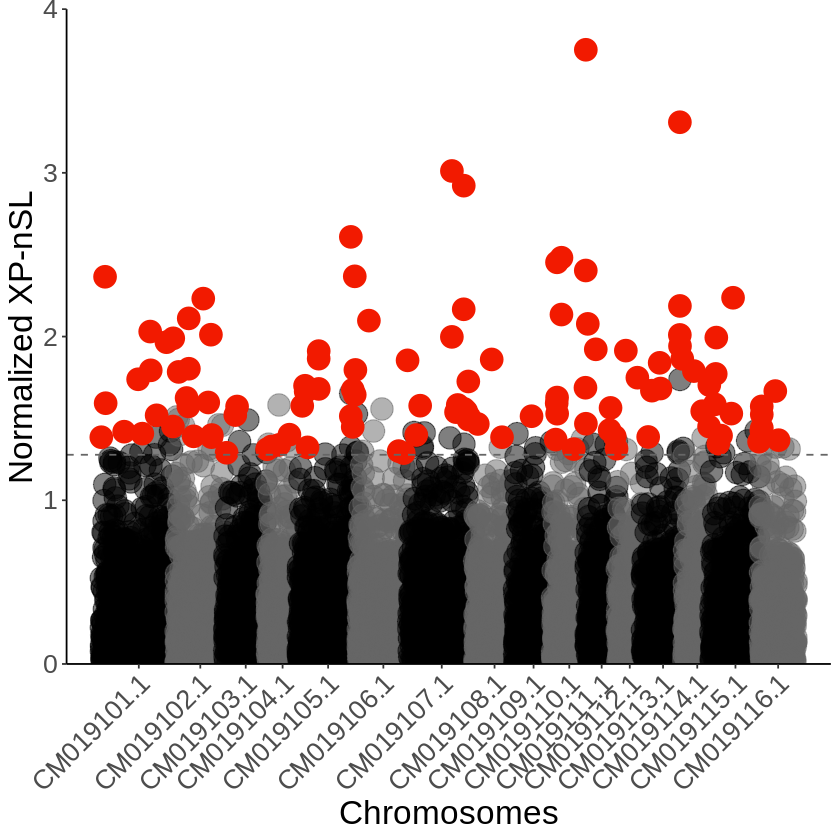

In [311]:
data_cum <- xpnsl_windows_filt %>% 
    group_by(Chr) %>% 
    summarise(max_winCenter = max(winCenter)) %>% 
    mutate(winCenter_add = lag(cumsum(max_winCenter), default = 0)) %>% 
    dplyr::select(Chr, winCenter_add)

xpnsl_windows_filt_mod <- xpnsl_windows_filt %>%
    inner_join(data_cum, by = "Chr") %>% 
    mutate(winCenter_cum = winCenter + winCenter_add) 

axis_set <- xpnsl_windows_filt_mod %>% 
  group_by(Chr) %>% 
  summarize(center = mean(winCenter_cum))

urban_outliers <- xpnsl_windows_filt_mod %>% filter(direction == 'Urban sel')
rural_outliers <- xpnsl_windows_filt_mod %>% filter(direction == 'Rural sel')

xpnsl_windows_filt_mod <- xpnsl_windows_filt_mod %>%
    mutate(chrom_cat = case_when(Chr == 'CM019101.1' ~ 'One',
                                 Chr == 'CM019102.1' ~ 'Two',
                                 Chr == 'CM019103.1' ~ 'One',
                                 Chr == 'CM019104.1' ~ 'Two',
                                 Chr == 'CM019105.1' ~ 'One',
                                 Chr == 'CM019106.1' ~ 'Two',
                                 Chr == 'CM019107.1' ~ 'One',
                                 Chr == 'CM019108.1' ~ 'Two',
                                 Chr == 'CM019109.1' ~ 'One',
                                 Chr == 'CM019110.1' ~ 'Two',
                                 Chr == 'CM019111.1' ~ 'One',
                                 Chr == 'CM019112.1' ~ 'Two',
                                 Chr == 'CM019113.1' ~ 'One',
                                 Chr == 'CM019114.1' ~ 'Two',
                                 Chr == 'CM019115.1' ~ 'One',
                                 Chr == 'CM019116.1' ~ 'Two')) %>%
    filter(direction == 'Not dual outlier') %>% 
    filter(mean >= 0) 

xpnsl_manhat <- ggplot() +
        geom_point(data = xpnsl_windows_filt_mod, shape = 21, alpha = 0.5, size = 6, 
                   aes(x = winCenter_cum, y = mean, fill = chrom_cat, color = chrom_cat)) +
        geom_point(data = urban_outliers, shape = 21, alpha = 1, size = 6, color = '#F21A00', fill = '#F21A00',
                   aes(x = winCenter_cum, y = mean)) +
#         geom_point(data = rural_outliers, shape = 21, alpha = 1, size = 1, color = 'green', fill = 'green') +
        geom_hline(yintercept = xpnsl_score_quant_filt, color = "grey40", linetype = "dashed") +
        scale_x_continuous(label = axis_set$Chr, breaks = axis_set$center) +
        scale_y_continuous(expand = c(0,0)) +
        coord_cartesian(ylim = c(0, 4)) +
        scale_fill_manual(values = c("black", "grey40")) + 
        scale_color_manual(values = c("black", "grey40")) + 
        ylab('Normalized XP-nSL') + xlab('Chromosomes') +
        theme_classic() +
        theme(
            legend.position = "none",
            panel.border = element_blank(),
            panel.grid.major.x = element_blank(),
            panel.grid.minor.x = element_blank(),
            axis.text = element_text(size=16),
            axis.title = element_text(size=20),
            axis.text.x = element_text(angle = 45, hjust = 1)
          )
xpnsl_manhat

In [313]:
ggsave(filename = paste0(figures_path, 'xpnsl_manhat.pdf'), plot = xpnsl_manhat, device = 'pdf', 
       width = 20, height = 6, units = 'in', dpi = 600, )

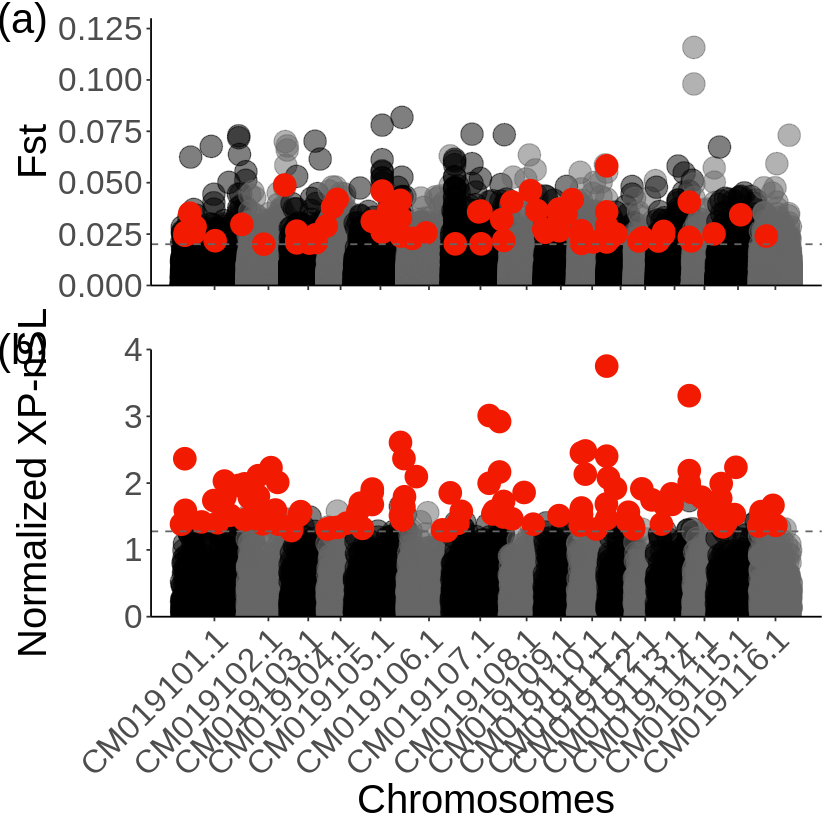

In [314]:
figure3 <- manhat_plot / xpnsl_manhat + 
    plot_annotation(tag_levels = 'a', tag_prefix = '(', tag_suffix = ')') &
    theme(plot.tag.position = c(0.005, 1.0),
        plot.tag = element_text(size = 25),
        axis.text = element_text(size=20),
        axis.title = element_text(size=24))
figure3

In [316]:
# ggsave(filename = paste0(figures_path, 'figure3.pdf'), plot = figure3, device = 'pdf', 
#        width = 25, height = 13, units = 'in', dpi = 600)
# ggsave(filename = paste0(figures_path, 'figure3.png'), plot = figure3, device = 'png', 
#        width = 25, height = 13, units = 'in', dpi = 600)
ggsave(filename = paste0(figures_path, 'figure3.jpeg'), plot = figure3, device = 'jpeg', 
    width = 25, height = 13, units = 'in', dpi = 600)

In [57]:
# Figure out rank of urban and rural outlier XP-nSL windows basd on proportion of outlier SNPs
xpnsl_urbanSel_windows <- xpnsl_windows_filt %>% 
    filter(direction == 'Urban sel') %>% 
    arrange(desc(gt_frac)) %>% 
    mutate(sel_habitat = 'Urban',
           sel_rank = 1:n())

xpnsl_ruralSel_windows <- xpnsl_windows_filt %>% 
    filter(direction == 'Rural sel') %>% 
    arrange(desc(lt_frac)) %>% 
    mutate(sel_habitat = 'Rural',
           sel_rank = 1:n())

xpnsl_sel_windows <- bind_rows(xpnsl_urbanSel_windows, xpnsl_ruralSel_windows) %>% 
    dplyr::select(Chr, start, end, everything())
xpnsl_sel_windows

Chr,start,end,winID,winCenter,mean,max,min,n,num_gt_thresh,num_lt_thresh,gt_frac,lt_frac,xpnsl_score_outlier,xpnsl_gtprop_outlier,xpnsl_ltprop_outlier,direction,sel_habitat,sel_rank
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<int>
CM019110.1,42721692,42771692,855,42746692,3.751715,5.50765,1.2374600,118,111,0,0.9406780,0,1,1,0,Urban sel,Urban,1
CM019113.1,48255570,48305570,966,48280570,3.309141,4.88937,1.4932700,233,213,0,0.9141631,0,1,1,0,Urban sel,Urban,2
CM019110.1,11471692,11521692,230,11496692,2.481507,4.16571,-1.1663400,145,121,0,0.8344828,0,1,1,0,Urban sel,Urban,3
CM019107.1,70656351,70706351,1414,70681351,2.921686,4.83873,0.6973880,294,244,0,0.8299320,0,1,1,0,Urban sel,Urban,4
CM019107.1,55456351,55506351,1110,55481351,3.011472,5.00904,-1.3711800,399,312,0,0.7819549,0,1,1,0,Urban sel,Urban,5
CM019113.1,48305570,48355570,967,48330570,2.187008,3.11410,0.3481650,84,61,0,0.7261905,0,1,1,0,Urban sel,Urban,6
CM019102.1,35041532,35091532,701,35066532,2.231649,4.54472,-1.6210300,539,370,0,0.6864564,0,1,1,0,Urban sel,Urban,7
CM019102.1,16591532,16641532,332,16616532,1.803370,4.22552,-0.7534990,107,72,0,0.6728972,0,1,1,0,Urban sel,Urban,8
CM019110.1,11421692,11471692,229,11446692,2.134439,2.64049,1.4441800,55,36,0,0.6545455,0,1,1,0,Urban sel,Urban,9


In [228]:
# Merge adjacent windows with exhibiting signatures of urban selection
xpnsl_urbanSel_windows_sorted <- xpnsl_urbanSel_windows %>% 
    dplyr::select(Chr, start, end, everything()) %>% 
    arrange(Chr, start)

xpnsl_urbanSel_windows_merged  <- bt.merge(i = xpnsl_urbanSel_windows_sorted, c = '6,7,12', o = 'mean,max,mean')
names(xpnsl_urbanSel_windows_merged) <- c('Chr', 'start', 'end', 'mean_xpnsl', 'max_xpnsl', 'mean_gt_frac')
xpnsl_urbanSel_windows_merged <- xpnsl_urbanSel_windows_merged %>% 
    mutate(winSize = end - start)

print(sprintf('There were %s XP-nSL outlier windows prior to merging. There are %s outlier regions after merging consecutive outlier windows',
              nrow(xpnsl_urbanSel_windows_sorted), nrow(xpnsl_urbanSel_windows_merged)))

[1] "There were 112 XP-nSL outlier windows prior to merging. There are 99 outlier regions after merging consecutive outlier windows"


## Overlap

In [230]:
xpnsl_sel_windows_pos <- xpnsl_urbanSel_windows_merged %>% 
    dplyr::select(Chr, start, end,)
fst_sel_windows_pos <- allStats_windowed_filt_urbanSel_withRanks %>% 
    dplyr::select(Chr, start, end)
print(sprintf("There are %s outlier XP-nSL regions and %s outlier Fst/pi/Td windows", nrow(xpnsl_sel_windows_pos), nrow(fst_sel_windows_pos)))

[1] "There are 99 outlier XP-nSL regions and 73 outlier Fst/pi/Td windows"


In [231]:
# Get concatenated XP-nSL regions that overlap with concatenated Fst regions
# Positions in terms of XP-nSL windows.
overlappingWindows_xpnsl_pos <- bt.intersect(xpnsl_sel_windows_pos, fst_sel_windows_pos, wa = T) %>% distinct()
names(overlappingWindows_xpnsl_pos) <- c('Chr', 'start', 'end')
overlappingWindows_xpnsl_pos

Chr,start,end
<fct>,<int>,<int>
CM019101.1,5610409,5660409
CM019105.1,26324753,26474753
CM019107.1,73806351,73856351
CM019109.1,21824979,21874979
CM019110.1,5321692,5371692
CM019110.1,5821692,5871692
CM019110.1,42671692,42771692
CM019113.1,48205570,48355570
CM019113.1,51305570,51355570


In [232]:
# Show XP-nSL region with at east one overapping Fst outlier region
xpnsl_regions_numFstOutliers <- bt.intersect(xpnsl_sel_windows_pos, fst_sel_windows_pos, c = T) %>% filter(V4 > 0)
names(xpnsl_regions_numFstOutliers) <- c('Chr', 'xpnsl_win_start', 'xpnsl_win_end', 'num_fst_outliers')
xpnsl_regions_numFstOutliers  <- xpnsl_regions_numFstOutliers %>% 
    mutate(size = xpnsl_win_end - xpnsl_win_start)
xpnsl_regions_numFstOutliers

Chr,xpnsl_win_start,xpnsl_win_end,num_fst_outliers,size
<fct>,<int>,<int>,<int>,<int>
CM019101.1,5610409,5660409,1,50000
CM019105.1,26324753,26474753,1,150000
CM019107.1,73806351,73856351,1,50000
CM019109.1,21824979,21874979,5,50000
CM019110.1,5321692,5371692,1,50000
CM019110.1,5821692,5871692,2,50000
CM019110.1,42671692,42771692,3,100000
CM019113.1,48205570,48355570,1,150000
CM019113.1,51305570,51355570,1,50000


In [233]:
# Get concatenated XP-nSL regions that overlap with concatenated Fst regions
# Positions in terms of Fst windows
overlappingWindows_fst_pos <- bt.intersect(fst_sel_windows_pos, xpnsl_sel_windows_pos, wa = T)
names(overlappingWindows_fst_pos) <- c('Chr', 'start', 'end')
overlappingWindows_fst_pos 

Chr,start,end
<fct>,<int>,<int>
CM019101.1,5615000,5620000
CM019105.1,26395000,26400000
CM019107.1,73825000,73830000
CM019109.1,21820000,21825000
CM019109.1,21825000,21830000
CM019109.1,21830000,21835000
CM019109.1,21835000,21840000
CM019109.1,21840000,21845000
CM019110.1,5360000,5365000


In [234]:
# Proportion of fst windows that overlap XP-nSL windows
nrow(overlappingWindows_fst_pos) / nrow(fst_sel_windows_pos)

[1] 0.2191781

In [235]:
# Get ranks of XP-nSL windows nested within overlapping outlier regions
bt.intersect(xpnsl_urbanSel_windows_sorted, overlappingWindows_xpnsl_pos) %>% 
    dplyr::select(V1, V2, V3, V19)

V1,V2,V3,V19
<fct>,<int>,<int>,<int>
CM019101.1,5610409,5660409,77
CM019105.1,26324753,26374753,59
CM019105.1,26374753,26424753,42
CM019105.1,26424753,26474753,67
CM019107.1,73806351,73856351,112
CM019109.1,21824979,21874979,94
CM019110.1,5321692,5371692,32
CM019110.1,5821692,5871692,106
CM019110.1,42671692,42721692,30


In [236]:
# Get ranks of Fst windows nested within overlapping outlier regions
bt.intersect(allStats_windowed_filt_urbanSel_withRanks, overlappingWindows_fst_pos) %>% 
    dplyr::select(V1, V2, V3, V13)

V1,V2,V3,V13
<fct>,<int>,<int>,<int>
CM019101.1,5615000,5620000,40
CM019105.1,26395000,26400000,24
CM019107.1,73825000,73830000,23
CM019109.1,21820000,21825000,11
CM019109.1,21825000,21830000,20
CM019109.1,21830000,21835000,12
CM019109.1,21835000,21840000,25
CM019109.1,21840000,21845000,34
CM019110.1,5360000,5365000,50


In [237]:
gff <- ape::read.gff('../resources/TrR.v5.renamed_reformated.gtf.gz', GFF3 = TRUE) %>% 
    dplyr::select(seqid, start, end, everything())

In [380]:
options(repr.matrix.max.rows=600, repr.matrix.max.cols=200)
outlier_genes_xpnsl_fst <- bt.intersect(gff, overlappingWindows_xpnsl_pos, wb = T) %>% 
    filter(V5 == 'transcript') %>% 
    dplyr::select(V1, V2, V3, V9, V11, V12)
names(outlier_genes_xpnsl_fst) <- c('Chr', 'transcript_start', 'transcript_end', 'annot', 'xpnsl_win_start', 'xpnsl_win_end')
outlier_genes_xpnsl_fst <- outlier_genes_xpnsl_fst %>% 
    mutate(func = str_extract(annot, pattern = '(?<=function=).*(?=;)'),
           accession = str_extract(annot, pattern = '(?<=accession).*(?=$)')) %>%
    dplyr::select(-annot) %>% 
    arrange(Chr, xpnsl_win_start)
outlier_genes_xpnsl_fst %>% distinct()

Chr,transcript_start,transcript_end,xpnsl_win_start,xpnsl_win_end,func,accession
<fct>,<int>,<int>,<int>,<int>,<chr>,<chr>
CM019101.1,5619831,5622190,5610409,5660409,26S proteasome regulatory particle non-ATPase subunit 12 [Medicago truncatula],AES59289.1
CM019101.1,5627667,5631146,5610409,5660409,hypothetical protein TSUD_06410 [Trifolium subterraneum],GAU26969.1
CM019101.1,5641096,5645082,5610409,5660409,protein NDL2 [Cicer arietinum],XP_004498913.1
CM019105.1,26324753,26326029,26324753,26474753,TLD domain-containing KIAA1609-like protein [Trifolium pratense],PNY07614.1
CM019105.1,26324753,26326029,26324753,26474753,programmed cell death protein [Medicago truncatula],KEH24185.1
CM019105.1,26332000,26344136,26324753,26474753,zinc finger CCCH domain-containing protein 19 [Medicago truncatula],XP_024635432.1
CM019105.1,26351903,26356187,26324753,26474753,endoglucanase 24-like protein [Trifolium pratense],PNY12761.1
CM019105.1,26365947,26366267,26324753,26474753,"transmembrane protein, putative [Medicago truncatula]",AES74262.1
CM019105.1,26375486,26377478,26324753,26474753,30S ribosomal protein mitochondrial-like [Trifolium pratense],PNX89188.1


In [241]:
xpnsl_urbanSel_windows_forJoin <- xpnsl_urbanSel_windows_merged %>% 
    dplyr::select(Chr, start, end, mean_xpnsl, max_xpnsl, mean_gt_frac) %>% 
    rename("xpnsl_win_start" = 'start',
           "xpnsl_win_end" = 'end') %>% 
    filter(xpnsl_win_start %in% outlier_genes_xpnsl_fst$xpnsl_win_start)
xpnsl_fst_overlap_transcripts <- outlier_genes_xpnsl_fst %>% 
    distinct() %>% 
    group_by(Chr, xpnsl_win_start, xpnsl_win_end) %>% 
    summarise(num_transcripts = n(),
              accessions = toString(accession)) %>% 
    left_join(xpnsl_regions_numFstOutliers, by = c('Chr', 'xpnsl_win_start', 'xpnsl_win_end')) %>% 
    left_join(xpnsl_urbanSel_windows_forJoin, by = c('Chr', 'xpnsl_win_start', 'xpnsl_win_end'))
xpnsl_fst_overlap_transcripts
write_csv(x = xpnsl_fst_overlap_transcripts, path = paste0(figures_path, 'xpnsl_fst_overlap_transcripts.csv'))

Warning message:
“Column `Chr` joining factors with different levels, coercing to character vector”Warning message:
“Column `Chr` joining character vector and factor, coercing into character vector”

Chr,xpnsl_win_start,xpnsl_win_end,num_transcripts,accessions,num_fst_outliers,size,mean_xpnsl,max_xpnsl,mean_gt_frac
<chr>,<int>,<int>,<int>,<chr>,<int>,<int>,<dbl>,<dbl>,<dbl>
CM019101.1,5610409,5660409,3,"AES59289.1, GAU26969.1, XP_004498913.1",1,50000,1.592835,3.91246,0.3372093
CM019105.1,26324753,26474753,22,"PNY07614.1, KEH24185.1, XP_024635432.1, PNY12761.1, AES74262.1, PNX89188.1, PNY08192.1, PNY08193.1, PNX93699.1, PNY10434.1, XP_024633788.1, RHN73807.1, XP_004500749.1, PNX68646.1, XP_004500757.1, AES71920.1, PNX96325.1, AES67419.2, XP_004500749.1, RDX72374.1, XP_017421192.1, ACZ67848.1",1,150000,1.818695,5.32534,0.3946968
CM019107.1,73806351,73856351,5,"RDY06969.1, PNY07179.1, RHN42408.1, PNX93229.1, PNX72376.1",1,50000,1.544264,3.64993,0.2686567
CM019109.1,21824979,21874979,4,"PNX85537.1, PNX96269.1, PNY05777.1, PNY07154.1",5,50000,1.513333,6.78105,0.3126984
CM019110.1,5321692,5371692,8,"PNX75326.1, PNY12614.1, XP_004511747.1, XP_004511749.1, XP_004511748.1, KEH19633.1, XP_021679125.1, AES94364.1",1,50000,1.592742,5.19988,0.4789272
CM019110.1,5821692,5871692,3,"XP_027366007.1, XP_004511754.1, AES94378.2",2,50000,1.627392,3.02624,0.2797203
CM019110.1,42671692,42771692,15,"XP_012573917.1, RHN41215.1, XP_024627446.1, AES97017.1, KEH15308.1, XP_004509927.2, AES94442.1, AES94440.1, AES94440.1, PNY12483.1, XP_004495520.1, PNX71624.1, XP_025698486.1, PNX68161.1, PNX74786.1",3,100000,3.077633,6.08258,0.7108453
CM019113.1,48205570,48355570,14,"AES94379.1, RDY03160.1, XP_003517385.1, PNY05495.1, PNY05496.1, PNY05497.1, PNY05248.1, PNY05247.1, XP_004511763.1, KEH27490.1, AES94392.1, AES94395.1, PNY12727.1, PNX99671.1",1,150000,2.502019,4.88937,0.7020357
CM019113.1,51305570,51355570,3,"PNY05848.1, XP_024626404.1, KEH36872.1",1,50000,1.863672,4.36404,0.4346154


In [378]:
# Annotations for Top XP-nSL hits
xpnsl_top10 <- xpnsl_urbanSel_windows %>% 
    filter(sel_rank <= 10) %>% 
    dplyr::select(Chr, start, end, sel_rank) %>% 
    arrange(Chr, start)
outlier_genes_xpnsl_top10 <- bt.intersect(gff, xpnsl_top10, wb = T) %>% 
    filter(V5 == 'transcript') %>% 
    dplyr::select(V1, V2, V3, V9, V11, V12, V13)
names(outlier_genes_xpnsl_top10) <- c('Chr', 'transcript_start', 'transcript_end', 'annot', 'xpnsl_win_start', 'xpnsl_win_end', 'sel_rank')

In [379]:
xpnsl_urbanSel_windows_forJoin <- xpnsl_urbanSel_windows %>% 
    dplyr::select(Chr, start, end, mean, max, gt_frac) %>% 
    rename("xpnsl_win_start" = 'start',
           "xpnsl_win_end" = 'end')
outlier_genes_xpnsl_top10 <- outlier_genes_xpnsl_top10 %>% 
    mutate(func = str_extract(annot, pattern = '(?<=function=).*(?=;)'),
           accession = str_extract(annot, pattern = '(?<=accession).*(?=$)')) %>%
    dplyr::select(-annot) %>% 
    arrange(sel_rank) %>% 
    distinct()
outlier_genes_xpnsl_top10

outlier_genes_xpnsl_top10 %>% 
    group_by(Chr, xpnsl_win_start, xpnsl_win_end) %>% 
    summarise(num_transcripts = n(),
              accessions = toString(accession)) %>% 
    left_join(outlier_genes_xpnsl_top10 %>% dplyr::select(Chr, xpnsl_win_start, xpnsl_win_end, sel_rank)) %>% 
    distinct() %>% 
    left_join(xpnsl_urbanSel_windows_forJoin, by = c('Chr', 'xpnsl_win_start', 'xpnsl_win_end')) %>% 
    write_csv(paste0(figures_path, 'xpnsl_top10_transcript.csv'))

Chr,transcript_start,transcript_end,xpnsl_win_start,xpnsl_win_end,sel_rank,func,accession
<fct>,<int>,<int>,<int>,<int>,<int>,<chr>,<chr>
CM019110.1,42721692,42722098,42721692,42771692,1,nucleoporin autopeptidase [Trifolium pratense],PNY12483.1
CM019110.1,42722148,42726120,42721692,42771692,1,nuclear pore complex protein NUP98A isoform X5 [Cicer arietinum],XP_004495520.1
CM019110.1,42737683,42738345,42721692,42771692,1,putative transcriptional regulator RABBIT EARS-like protein [Trifolium pratense],PNX71624.1
CM019110.1,42762906,42763316,42721692,42771692,1,auxin-responsive protein SAUR77-like [Arachis hypogaea],XP_025698486.1
CM019110.1,42765139,42765426,42721692,42771692,1,ribonuclease H [Trifolium pratense],PNX68161.1
CM019110.1,42767343,42771692,42721692,42771692,1,metacaspase 7 [Trifolium pratense],PNX74786.1
CM019113.1,48255570,48263371,48255570,48305570,2,regulator of nonsense transcripts 1 homolog [Glycine max],XP_003517385.1
CM019113.1,48274550,48279242,48255570,48305570,2,ras-related protein RABH1b-like [Trifolium pratense],PNY05495.1
CM019113.1,48283294,48285177,48255570,48305570,2,pyrophosphatase ppaX [Trifolium pratense],PNY05496.1


Joining, by = c("Chr", "xpnsl_win_start", "xpnsl_win_end")
Warning message:
“Column `Chr` joining factor and character vector, coercing into character vector”

In [110]:
xpnsl_raw_df %>% filter(normxpnsl == max(xpnsl_raw_df %>% pull(normxpnsl))

pos,gpos,p1,sL1,p2,sL2,xpnsl,normxpnsl,crit,Chr
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
21842563,101833,0.243902,30.2748,0.378049,12.0744,0.399216,6.78105,1,CM019109.1


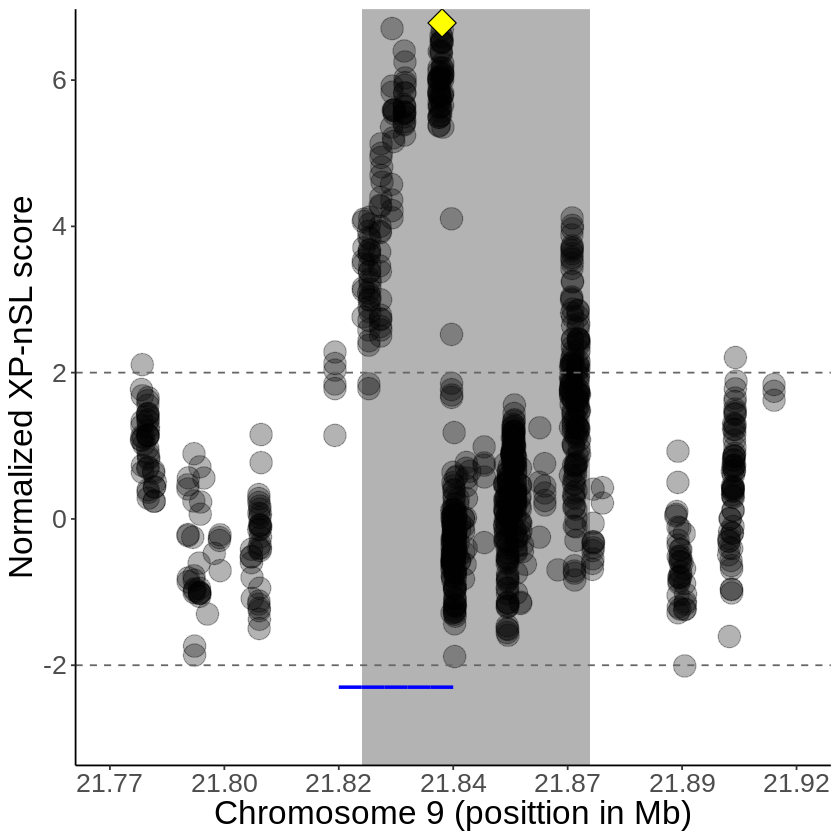

In [360]:
min_pos <- 21824979
max_pos <- 21874979
buffer <- 50000
highest_xpnsl_score <- xpnsl_raw_df %>% filter(normxpnsl == max(xpnsl_raw_df %>% pull(normxpnsl)))
chr9_outlier_region <- xpnsl_raw_df %>%
    filter(Chr == 'CM019109.1' & pos >= min_pos - buffer & pos <= 21874979 + buffer) %>% 
    filter(!(gpos %in% highest_xpnsl_score$gpos))

formatter1e6 <- function(x){ 
    x <- x / 1e6
    return(sprintf(x, fmt = '%#.2f'))
}

xmin = 21770000
xmax = 21920000

fst_wins <- overlappingWindows_fst_pos %>% filter(Chr == 'CM019109.1')

chr9_outlier_region_manhat <- ggplot(chr9_outlier_region, aes(x = pos, y = normxpnsl)) +
    annotate(geom = "rect", xmin = min_pos, xmax = max_pos, ymin = -Inf, ymax = Inf, fill = 'black', alpha = 0.3) +
    geom_point(shape = 21, size = 6, fill = 'black', alpha = 0.3) +
    geom_point(data = highest_xpnsl_score, shape = 23, size = 6, fill = 'yellow', alpha = 1) +
    geom_hline(yintercept = 2, color = "grey40", linetype = "dashed") +
    geom_hline(yintercept = -2, color = "grey40", linetype = "dashed") +
    xlab('Chromosome 9 (posittion in Mb)') + ylab('Normalized XP-nSL score') +
    coord_cartesian(xlim = c(xmin, xmax), ylim = c(-2.9, 6.5)) +
    scale_x_continuous(breaks = seq(xmin, xmax, 25000), labels = formatter1e6) +
    scale_y_continuous(breaks = seq(-2, 6, 2)) +
    geom_segment(data = fst_wins, aes(x = start, xend = end), y = -2.3, yend = -2.3, color = 'blue', size = 1) +
    theme_classic() +
    theme(
        panel.border = element_blank(),
        panel.grid.major.x = element_blank(),
        panel.grid.minor.x = element_blank(),
        axis.text = element_text(size=16),
        axis.title = element_text(size=20),
      )
chr9_outlier_region_manhat

In [364]:
ggsave(filename = paste0(figures_path, 'chr9_outlier_region_manhat.pdf'), plot = chr9_outlier_region_manhat, device = 'pdf', 
       width = 12, height = 8, units = 'in', dpi = 600, )

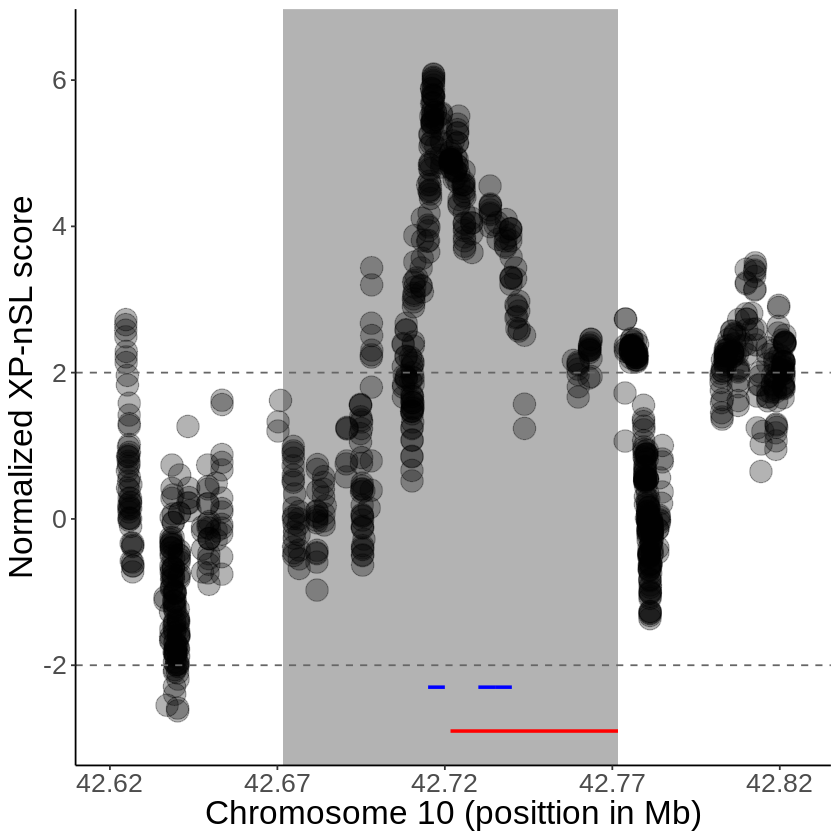

In [362]:
min_pos <- 42671692
max_pos <- 42771692
buffer <- 50000
# highest_xpnsl_score <- xpnsl_raw_df %>% filter(normxpnsl == max(xpnsl_raw_df %>% pull(normxpnsl)))
chr10_outlier_region <- xpnsl_raw_df %>%
    filter(Chr == 'CM019110.1' & pos >= min_pos - buffer & pos <= max_pos + buffer) 
# %>% 
#     filter(!(gpos %in% highest_xpnsl_score$gpos))

formatter1e6 <- function(x){ 
    x <- x / 1e6
    return(sprintf(x, fmt = '%#.2f'))
}

xmin = 42670000 - buffer
xmax = 42775000 + buffer

fst_wins <- overlappingWindows_fst_pos %>% filter(Chr == 'CM019110.1')

# Get ranks of XP-nSL windows nested within overlapping outlier regions
top_xpnsl <- bt.intersect(xpnsl_urbanSel_windows_sorted, overlappingWindows_xpnsl_pos) %>% 
    dplyr::select(V1, V2, V3, V19) %>% 
    filter(V19 == 1) %>% 
    rename('start' = 'V2',
          'end' = 'V3')

chr10_outlier_region_manhat <- ggplot(chr10_outlier_region, aes(x = pos, y = normxpnsl)) +
    annotate(geom = "rect", xmin = min_pos, xmax = max_pos, ymin = -Inf, ymax = Inf, fill = 'black', alpha = 0.3) +
    geom_point(shape = 21, size = 6, fill = 'black', alpha = 0.3) +
#     geom_point(data = highest_xpnsl_score, shape = 23, size = 6, fill = 'red', alpha = 1) +
    geom_hline(yintercept = 2, color = "grey40", linetype = "dashed") +
    geom_hline(yintercept = -2, color = "grey40", linetype = "dashed") +
    xlab('Chromosome 10 (posittion in Mb)') + ylab('Normalized XP-nSL score') +
    coord_cartesian(xlim = c(xmin, xmax), ylim = c(-2.9, 6.5)) +
    scale_x_continuous(breaks = seq(xmin, xmax, 50000), labels = formatter1e6) +
    scale_y_continuous(breaks = seq(-2, 6, 2)) +
    geom_segment(data = fst_wins, aes(x = start, xend = end), y = -2.3, yend = -2.3, color = 'blue', size = 1) +
    geom_segment(data = top_xpnsl, aes(x = start, xend = end), y = -2.9, yend = -2.9, color = 'red', size = 1) +
    theme_classic() +
    theme(
        panel.border = element_blank(),
        panel.grid.major.x = element_blank(),
        panel.grid.minor.x = element_blank(),
        axis.text = element_text(size=16),
        axis.title = element_text(size=20),
      )
chr10_outlier_region_manhat

In [363]:
ggsave(filename = paste0(figures_path, 'chr10_outlier_region_manhat.pdf'), plot = chr10_outlier_region_manhat, device = 'pdf', 
       width = 12, height = 8, units = 'in', dpi = 600, )

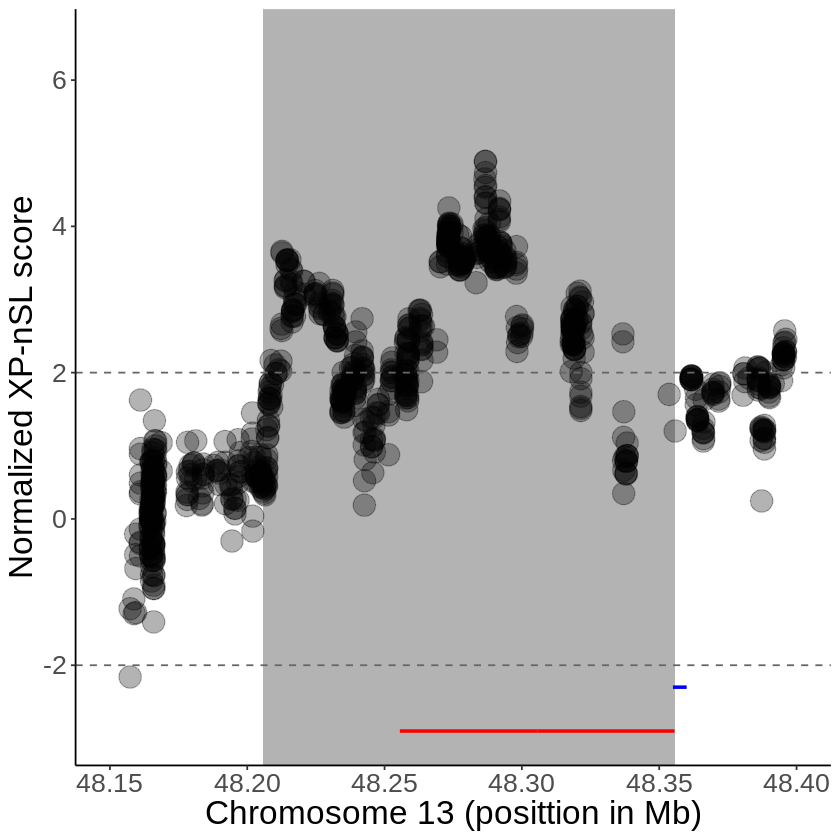

In [365]:
min_pos <- 48205570
max_pos <- 48355570
buffer <- 50000
# highest_xpnsl_score <- xpnsl_raw_df %>% filter(normxpnsl == max(xpnsl_raw_df %>% pull(normxpnsl)))
chr13_outlier_region <- xpnsl_raw_df %>%
    filter(Chr == 'CM019113.1' & pos >= min_pos - buffer & pos <= max_pos + buffer) 
# %>% 
#     filter(!(gpos %in% highest_xpnsl_score$gpos))

formatter1e6 <- function(x){ 
    x <- x / 1e6
    return(sprintf(x, fmt = '%#.2f'))
}

xmin = 48200000 - buffer
xmax = 48350000 + buffer

fst_wins <- overlappingWindows_fst_pos %>% filter(Chr == 'CM019113.1')

# Get ranks of XP-nSL windows nested within overlapping outlier regions
top_xpnsl <- bt.intersect(xpnsl_urbanSel_windows_sorted, overlappingWindows_xpnsl_pos) %>% 
    dplyr::select(V1, V2, V3, V19) %>% 
    filter(V19 %in% c(2, 6)) %>% 
    rename('start' = 'V2',
          'end' = 'V3')

chr13_outlier_region_manhat <- ggplot(chr13_outlier_region, aes(x = pos, y = normxpnsl)) +
    annotate(geom = "rect", xmin = min_pos, xmax = max_pos, ymin = -Inf, ymax = Inf, fill = 'black', alpha = 0.3) +
    geom_point(shape = 21, size = 6, fill = 'black', alpha = 0.3) +
#     geom_point(data = highest_xpnsl_score, shape = 23, size = 6, fill = 'red', alpha = 1) +
    geom_hline(yintercept = 2, color = "grey40", linetype = "dashed") +
    geom_hline(yintercept = -2, color = "grey40", linetype = "dashed") +
    xlab('Chromosome 13 (posittion in Mb)') + ylab('Normalized XP-nSL score') +
    coord_cartesian(xlim = c(xmin, xmax), ylim = c(-2.9, 6.5)) +
    scale_x_continuous(breaks = seq(xmin, xmax, 50000), labels = formatter1e6) +
    scale_y_continuous(breaks = seq(-2, 6, 2)) +
    geom_segment(data = fst_wins, aes(x = start, xend = end), y = -2.3, yend = -2.3, color = 'blue', size = 1) +
    geom_segment(data = top_xpnsl, aes(x = start, xend = end), y = -2.9, yend = -2.9, color = 'red', size = 1) +
    theme_classic() +
    theme(
        panel.border = element_blank(),
        panel.grid.major.x = element_blank(),
        panel.grid.minor.x = element_blank(),
        axis.text = element_text(size=16),
        axis.title = element_text(size=20),
      )
chr13_outlier_region_manhat

In [366]:
ggsave(filename = paste0(figures_path, 'chr13_outlier_region_manhat.pdf'), plot = chr13_outlier_region_manhat, device = 'pdf', 
       width = 12, height = 8, units = 'in', dpi = 600, )

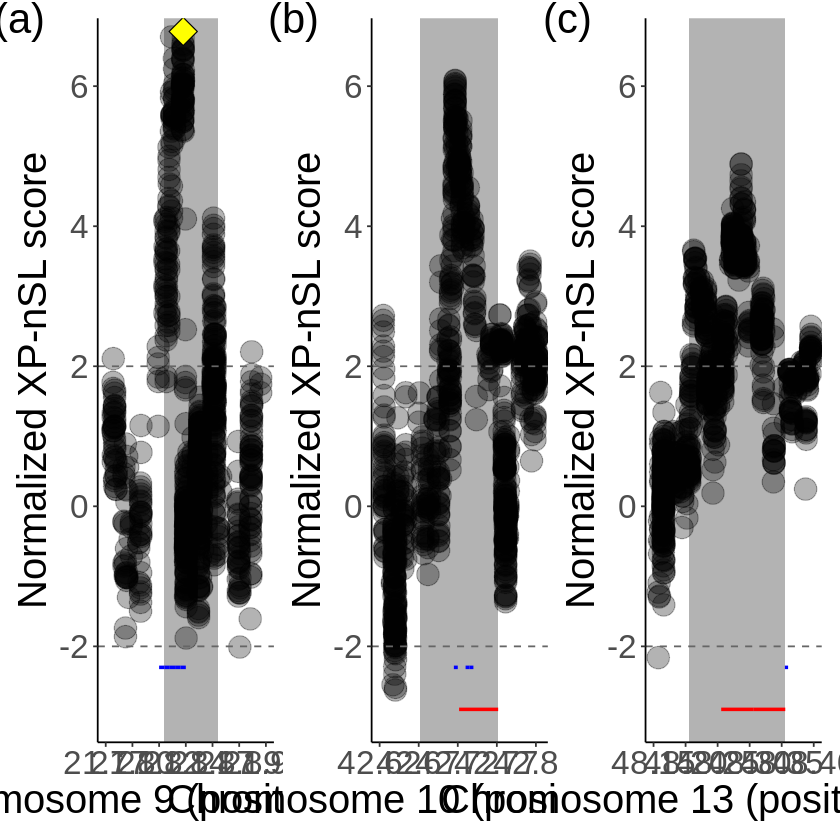

In [367]:
figure4 <- chr9_outlier_region_manhat + chr10_outlier_region_manhat + chr13_outlier_region_manhat + 
    plot_annotation(tag_levels = 'a', tag_prefix = '(', tag_suffix = ')') &
    theme(plot.tag.position = c(0.005, 1.0),
        plot.tag = element_text(size = 25),
        axis.text = element_text(size=20),
        axis.title = element_text(size=24))
figure4

In [368]:
ggsave(filename = paste0(figures_path, 'figure4.pdf'), plot = figure4, device = 'pdf', 
       width = 25, height = 8, units = 'in', dpi = 600, )
ggsave(filename = paste0(figures_path, 'figure4.png'), plot = figure4, device = 'png', 
       width = 25, height = 8, units = 'in', dpi = 600, )
ggsave(filename = paste0(figures_path, 'figure4.jpeg'), plot = figure4, device = 'jpeg', 
       width = 25, height = 8, units = 'in', dpi = 600, )

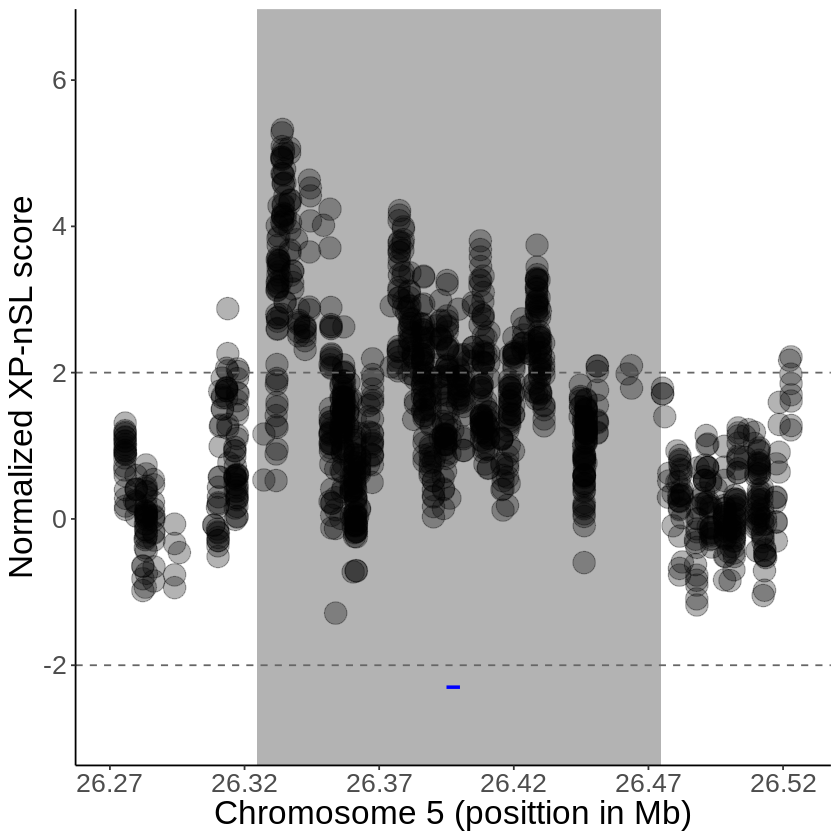

In [381]:
min_pos <- 26324753
max_pos <- 26474753
buffer <- 50000
# highest_xpnsl_score <- xpnsl_raw_df %>% filter(normxpnsl == max(xpnsl_raw_df %>% pull(normxpnsl)))
chr5_outlier_region <- xpnsl_raw_df %>%
    filter(Chr == 'CM019105.1' & pos >= min_pos - buffer & pos <= max_pos + buffer) 
# %>% 
#     filter(!(gpos %in% highest_xpnsl_score$gpos))

formatter1e6 <- function(x){ 
    x <- x / 1e6
    return(sprintf(x, fmt = '%#.2f'))
}

xmin = 26320000 - buffer
xmax = 26475000 + buffer

fst_wins <- overlappingWindows_fst_pos %>% filter(Chr == 'CM019105.1')

# Get ranks of XP-nSL windows nested within overlapping outlier regions
top_xpnsl <- bt.intersect(xpnsl_urbanSel_windows_sorted, overlappingWindows_xpnsl_pos) %>% 
    dplyr::select(V1, V2, V3, V19) %>% 
    filter(V19 %in% c(2, 6)) %>% 
    rename('start' = 'V2',
          'end' = 'V3')

chr5_outlier_region_manhat <- ggplot(chr5_outlier_region, aes(x = pos, y = normxpnsl)) +
    annotate(geom = "rect", xmin = min_pos, xmax = max_pos, ymin = -Inf, ymax = Inf, fill = 'black', alpha = 0.3) +
    geom_point(shape = 21, size = 6, fill = 'black', alpha = 0.3) +
#     geom_point(data = highest_xpnsl_score, shape = 23, size = 6, fill = 'red', alpha = 1) +
    geom_hline(yintercept = 2, color = "grey40", linetype = "dashed") +
    geom_hline(yintercept = -2, color = "grey40", linetype = "dashed") +
    xlab('Chromosome 5 (posittion in Mb)') + ylab('Normalized XP-nSL score') +
    coord_cartesian(xlim = c(xmin, xmax), ylim = c(-2.9, 6.5)) +
    scale_x_continuous(breaks = seq(xmin, xmax, 50000), labels = formatter1e6) +
    scale_y_continuous(breaks = seq(-2, 6, 2)) +
    geom_segment(data = fst_wins, aes(x = start, xend = end), y = -2.3, yend = -2.3, color = 'blue', size = 1) +
    geom_segment(data = top_xpnsl, aes(x = start, xend = end), y = -2.9, yend = -2.9, color = 'red', size = 1) +
    theme_classic() +
    theme(
        panel.border = element_blank(),
        panel.grid.major.x = element_blank(),
        panel.grid.minor.x = element_blank(),
        axis.text = element_text(size=16),
        axis.title = element_text(size=20),
      )
chr5_outlier_region_manhat

## Playing around

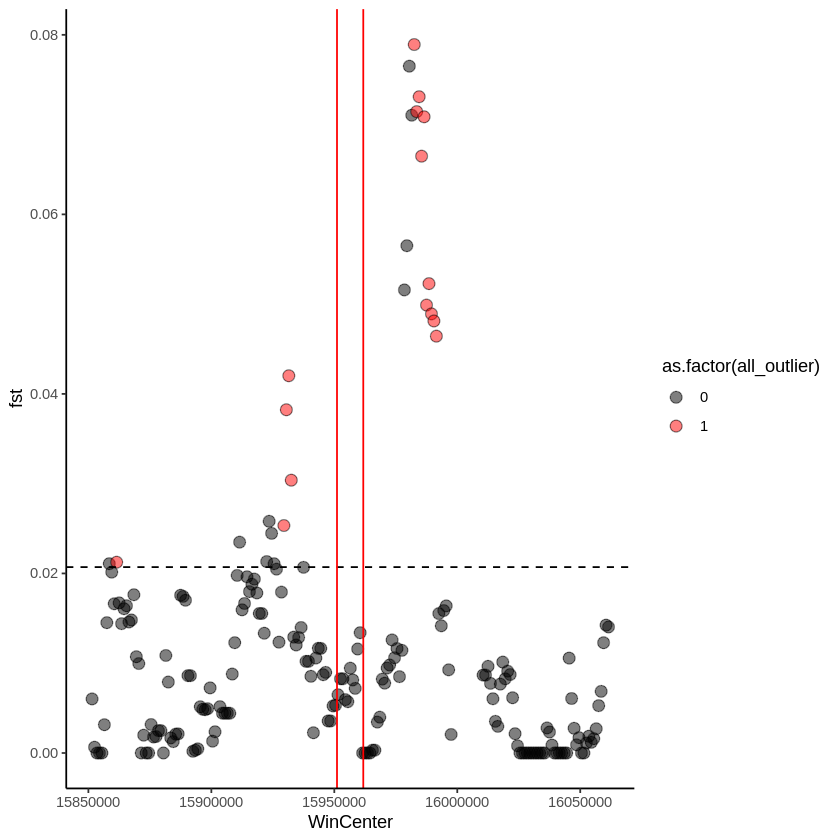

In [22]:
fst_quant <- quantile(testChr_allStats %>% pull(fst), probs = c(0.99))
tp_quant <- quantile(testChr_allStats %>% pull(delta_tp_ur), probs = c(0.01, 0.99))
td_quant <- quantile(testChr_allStats %>% pull(delta_td_ur), probs = c(0.01, 0.99))
Ac_outlier_df <- testChr_allStats %>%
    filter(WinCenter >= 15951095 - 100000 & WinCenter <= 15961779 + 100000) %>%
    mutate(fst_outlier = ifelse(fst >= fst_quant, 1, 0),
           tp_outlier = ifelse(delta_tp_ur <= tp_quant[1] | delta_tp_ur >= tp_quant[2], 1, 0),
           td_outlier = ifelse(delta_td_ur <= td_quant[1] | delta_td_ur >= td_quant[2], 1, 0),
           all_outlier = ifelse(fst_outlier == 1 & tp_outlier == 1 & td_outlier == 1, 1, 0))
Ac_outlier_df %>%
    ggplot(., aes(x = WinCenter, y = fst)) +
        geom_point(size = 3, alpha = 0.5, shape = 21, aes(fill = as.factor(all_outlier))) +
        geom_hline(yintercept = fst_quant, color = 'black', size = 0.5, linetype = 'dashed') +
        scale_fill_manual(values = c('black', 'red')) +
        geom_vline(xintercept = 15951095, color = 'red') +
        geom_vline(xintercept = 15961779, color = 'red') + 
        theme_classic()